In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# Importing the data
# Load the provided CSV data again after the environment reset
path = ".\Quantitative Research Intern data\CRWV\CRWV_2025-04-03 00_00_00+00_00.csv"
df = pd.read_csv(path)

# Display first few rows to understand structure
df.head(10)

,ts_event,ts_event.1,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
0,2025-04-03 13:30:00.012155347+00:00,2025-04-03 13:30:00.012155347+00:00,10,2,20613,T,B,0,55.40,99,...,4,1,1,54.55,56.70,100,10,1,1,CRWV
1,2025-04-03 13:30:00.012155347+00:00,2025-04-03 13:30:00.012155347+00:00,10,2,20613,T,B,0,55.40,100,...,4,1,1,54.55,56.70,100,10,1,1,CRWV
2,2025-04-03 13:30:00.012155347+00:00,2025-04-03 13:30:00.012155347+00:00,10,2,20613,T,N,0,55.40,551,...,10,1,1,54.55,56.91,100,100,1,1,CRWV
3,2025-04-03 13:30:00.012344442+00:00,2025-04-03 13:30:00.012344442+00:00,10,2,20613,A,A,0,55.40,100,...,4,1,1,54.55,56.70,100,10,1,1,CRWV
4,2025-04-03 13:30:00.012800457+00:00,2025-04-03 13:30:00.012800457+00:00,10,2,20613,A,B,0,55.39,100,...,4,1,1,54.57,56.70,400,10,1,1,CRWV
5,2025-04-03 13:30:00.013396841+00:00,2025-04-03 13:30:00.013396841+00:00,10,2,20613,C,B,0,53.68,100,...,4,1,1,54.55,56.70,100,10,1,1,CRWV
6,2025-04-03 13:30:00.120353811+00:00,2025-04-03 13:30:00.120353811+00:00,10,2,20613,A,B,0,55.28,100,...,4,1,1,54.57,56.70,400,10,1,1,CRWV
7,2025-04-03 13:30:00.121870648+00:00,2025-04-03 13:30:00.121870648+00:00,10,2,20613,T,B,0,55.40,100,...,4,1,1,54.57,56.70,400,10,1,1,CRWV
8,2025-04-03 13:30:00.121870648+00:00,2025-04-03 13:30:00.121870648+00:00,10,2,20613,C,A,0,55.40,100,...,10,1,1,54.57,56.83,400,100,1,1,CRWV
9,2025-04-03 13:30:00.121873007+00:00,2025-04-03 13:30:00.121873007+00:00,10,2,20613,T,N,0,55.40,100,...,10,1,1,54.57,56.83,400,100,1,1,CRWV


### MBP-10 is a Level 2 (L2) order book data feed that includes only the best 10 bid and ask prices, their sizes, and order counts. This is a standard practice because: 

- Most trades occur near the top of the book (best bid/ask prices).

- Data beyond 10 levels is often not critical for short-term trading strategies and would create large data overhead.

In [29]:
# 2. ORDER BOOK SNAPSHOT
def get_order_book_snapshot(df, index=0):
    """
    Extracts a single snapshot (top 10 bid/ask) from MBP-10 data.
    """
    row = df.iloc[index]
    ask_prices = [row[f'ask_px_{i:02}'] for i in range(10)]
    bid_prices = [row[f'bid_px_{i:02}'] for i in range(10)]
    ask_sizes = [row[f'ask_sz_{i:02}'] for i in range(10)]
    bid_sizes = [row[f'bid_sz_{i:02}'] for i in range(10)]
    return pd.DataFrame({
        'ask_px': ask_prices,
        'ask_sz': ask_sizes,
        'bid_px': bid_prices,
        'bid_sz': bid_sizes
    })

order_book = get_order_book_snapshot(df, index=0)
print(order_book)

   ask_px  ask_sz  bid_px  bid_sz
0   55.40     199   55.10       1
1   55.46      10   55.06    1667
2   55.47     100   55.03     200
3   55.50     100   55.00      80
4   55.93      50   54.98      20
5   56.00     200   54.80      10
6   56.24       3   54.78     100
7   56.45       5   54.66       1
8   56.66       4   54.57     400
9   56.70      10   54.55     100


In [30]:
# 3. Defining the SLIPPAGE calculation function
def calculate_slippage(order_book, x):
    ask_prices = order_book['ask_px'].values
    ask_sizes = order_book['ask_sz'].values

    shares_remaining = x
    cost = 0
    for price, size in zip(ask_prices, ask_sizes):
        shares_to_buy = min(size, shares_remaining)
        cost += (shares_to_buy * price)
        shares_remaining -= shares_to_buy
        if shares_remaining <= 0:
            break

    if shares_remaining > 0:
        cost += shares_remaining * ask_prices[-1]

    avg_price = cost / x
    mid_price = (order_book['ask_px'].iloc[0] + order_book['bid_px'].iloc[0]) / 2
    return avg_price - mid_price


In [31]:
# 4. simulating the slippage of a stock order book
def simulate_slippage(order_book, max_x=30000, step=500):
    x_values = list(range(step, max_x + step, step))
    g_values = [calculate_slippage(order_book, x) for x in x_values]
    return x_values, g_values

x_values, g_values = simulate_slippage(order_book)


In [32]:
# 5. FIT QUADRATIC MODEL
def fit_quadratic(x, g):
    x = np.array(x)
    g = np.array(g)
    A = np.vstack([x, x**2]).T
    a, b = np.linalg.lstsq(A, g, rcond=None)[0]
    return a, b

a, b = fit_quadratic(x_values, g_values)
print(f"Fitted Model: g_t(x) = {a:.4f}x + {b:.6f}x²")

Fitted Model: g_t(x) = 0.0002x + -0.000000x²


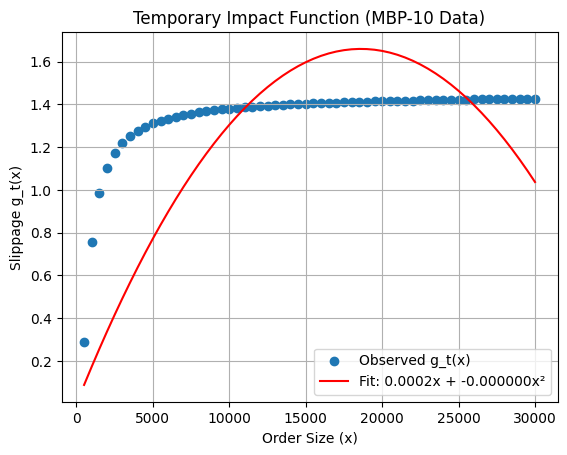

In [33]:
# 6. VISUALIZATION
plt.scatter(x_values, g_values, label='Observed g_t(x)')
plt.plot(x_values, [a*x + b*x**2 for x in x_values], 'r-', label=f'Fit: {a:.4f}x + {b:.6f}x²')
plt.xlabel('Order Size (x)')
plt.ylabel('Slippage g_t(x)')
plt.title('Temporary Impact Function (MBP-10 Data)')
plt.legend()
plt.grid(True)
plt.show()